

# Projet Natural Language Processing - Sentiment Analysis - Ghislain Sartorius






# Organisation des étapes du code
I. Importation des données

II. Prétraitement des données

III.	Préparation des données pour l’entraînement

IV.	Création du modèle, entraînement

V.	Tests de prédiction





On importe les différents modules que nous allons utiliser : tensorflow, numpy, pandas, etc..
Pour la création de notre modèle, nous utilisons des layers de keras

Nous utilisons aussi des fonctions (sequence, pad_sequences, etc) de keras pour transformer nos phrases en vecteurs (explications plus bas)

In [170]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

from keras.models import Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [171]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


# I. Importation des données
On importe le jeu de données disponnible sur le drive (changer le chemin pour le faire fonctionner)

In [172]:
df = pd.read_csv('gdrive/MyDrive/Colab Notebooks/Projet/training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None)

df.columns = ['target','id','date','flag','user','text']

Et on visualise le jeu de données

In [173]:
#Visualize dataframe
df

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


On peut voir qu'il y a 1600000 tweets, avec 6 colonnes (target(le sentiment), id du tweet, la date, flag, l'utilisateur qui a tweeté et le tweet (text))

In [174]:
print("Shape : " + str(df.shape))
print("Length : " + str(len(df)))

Shape : (1600000, 6)
Length : 1600000


Le seules colonnes qui nous intéressent sont celles du sentiment et le texte, on ne garde donc que celles-là dans notre jeu de données

In [175]:
# We keep only targets and text
df = df[['target','text']]
df

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


# II. Préraitement des données
Maintenant que nous avons ce qui nous intéresse, il va falloir traiter le texte

On commence par la fonction clean_tweet, qui va permettre d'enlever les liens (www., http:://), les mentions (@user), les zones vides, ainsi que les hashtags

On crée une nouvelle colonne dans notre dataframe, dans laquelle on mets le tweet "nettoyé"

In [176]:
import re
def clean_tweet(text):
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',text) #remove links
    text = re.sub('@[^\s]+',' ', text) #remove mentions
    text = re.sub('[\s]+', ' ', text) #remove blanks
    text = re.sub(r'#([^\s]+)', r' ', text) #remove #
    return text
df['clean_tweet'] = df.text.apply(clean_tweet)
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,target,text,clean_tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","- Awww, that's a bummer. You shoulda got Davi..."
1,0,is upset that he can't update his Facebook by ...,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...,I dived many times for the ball. Managed to s...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....","no, it's not behaving at all. i'm mad. why am..."
...,...,...,...
1599995,4,Just woke up. Having no school is the best fee...,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...,Happy 38th Birthday to my boo of alll time!!! ...


Ensuite, nous continuons le nettoyage des tweets en supprimant les ponctuations (on décide de ne garder que les lettres). Puis on mets toutes nos lettres en minuscule. Enfin, on supprime les stopwords. Les tweets étant en anglais, on utilise le dictionnaire de stopwords anglais.

On remplace les tweets de la colonne clean_tweets par les nouveaux tweets

In [177]:
#Remove punctiations, numbers, uppercases letters and stopwords in tweets
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))
def remove_punct(text):
    text = text.str.replace('[^a-zA-Z#]',' ') # keep only letters, if not a letter replace with space
    text = text.str.lower() #remove uppercases letters
    text = text.apply(lambda x: ' '.join(w for w in x.split() if w not in stopWords)) # remove stopwords
    return text
df['clean_tweet'] = remove_punct(df['clean_tweet'])
df 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,target,text,clean_tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww bummer shoulda got david carr third day
1,0,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...
2,0,@Kenichan I dived many times for the ball. Man...,dived many times ball managed save rest go bounds
3,0,my whole body feels itchy and like its on fire,whole body feels itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",behaving mad see
...,...,...,...
1599995,4,Just woke up. Having no school is the best fee...,woke school best feeling ever
1599996,4,TheWDB.com - Very cool to hear old Walt interv...,thewdb com cool hear old walt interviews
1599997,4,Are you ready for your MoJo Makeover? Ask me f...,ready mojo makeover ask details
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...,happy th birthday boo alll time tupac amaru sh...


L'étape suivante est le Stemming. Pour procéder, nous devons tokenizer chaque tweet en splitant simplement les mots dans les tweets

In [178]:
#tokenize texts
tokenized_text = df['clean_tweet'].apply(lambda x: x.split())
tokenized_text.head()

0    [awww, bummer, shoulda, got, david, carr, thir...
1    [upset, update, facebook, texting, might, cry,...
2    [dived, many, times, ball, managed, save, rest...
3              [whole, body, feels, itchy, like, fire]
4                                 [behaving, mad, see]
Name: clean_tweet, dtype: object

Puis nous appliquons le Stemming (PorterStemming) à nos tokens (l'étape est assez longue)

In [179]:
#stemming words
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_text = tokenized_text.apply(lambda x: [stemmer.stem(i) for i in x])
tokenized_text.head()

0    [awww, bummer, shoulda, got, david, carr, thir...
1    [upset, updat, facebook, text, might, cri, res...
2    [dive, mani, time, ball, manag, save, rest, go...
3               [whole, bodi, feel, itchi, like, fire]
4                                    [behav, mad, see]
Name: clean_tweet, dtype: object

Nous créons une nouvelle colonne représentant les tokens + Stemming des tweets

In [180]:
df['tokens'] = tokenized_text
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,target,text,clean_tweet,tokens
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww bummer shoulda got david carr third day,"[awww, bummer, shoulda, got, david, carr, thir..."
1,0,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...,"[upset, updat, facebook, text, might, cri, res..."
2,0,@Kenichan I dived many times for the ball. Man...,dived many times ball managed save rest go bounds,"[dive, mani, time, ball, manag, save, rest, go..."
3,0,my whole body feels itchy and like its on fire,whole body feels itchy like fire,"[whole, bodi, feel, itchi, like, fire]"
4,0,"@nationwideclass no, it's not behaving at all....",behaving mad see,"[behav, mad, see]"
...,...,...,...,...
1599995,4,Just woke up. Having no school is the best fee...,woke school best feeling ever,"[woke, school, best, feel, ever]"
1599996,4,TheWDB.com - Very cool to hear old Walt interv...,thewdb com cool hear old walt interviews,"[thewdb, com, cool, hear, old, walt, interview]"
1599997,4,Are you ready for your MoJo Makeover? Ask me f...,ready mojo makeover ask details,"[readi, mojo, makeov, ask, detail]"
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...,happy th birthday boo alll time tupac amaru sh...,"[happi, th, birthday, boo, alll, time, tupac, ..."


Enfin, nous recréons les phrases en rassemblant tous les tokens. Nous obtenons donc les tweets finaux, qui vont nous servir pour l'entrainement.
Ces textes sont placés dans une nouvelle colonne, *clean_tweet_final*

In [181]:
# now let's see how clean tweets look like in the dataframe
for i in range(len(tokenized_text)):
    tokenized_text[i] = ' '.join(tokenized_text[i])

df['clean_tweet_final'] = tokenized_text

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [182]:
df

,target,text,clean_tweet,tokens,clean_tweet_final
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww bummer shoulda got david carr third day,"[awww, bummer, shoulda, got, david, carr, thir...",awww bummer shoulda got david carr third day
1,0,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...,"[upset, updat, facebook, text, might, cri, res...",upset updat facebook text might cri result sch...
2,0,@Kenichan I dived many times for the ball. Man...,dived many times ball managed save rest go bounds,"[dive, mani, time, ball, manag, save, rest, go...",dive mani time ball manag save rest go bound
3,0,my whole body feels itchy and like its on fire,whole body feels itchy like fire,"[whole, bodi, feel, itchi, like, fire]",whole bodi feel itchi like fire
4,0,"@nationwideclass no, it's not behaving at all....",behaving mad see,"[behav, mad, see]",behav mad see
...,...,...,...,...,...
1599995,4,Just woke up. Having no school is the best fee...,woke school best feeling ever,"[woke, school, best, feel, ever]",woke school best feel ever
1599996,4,TheWDB.com - Very cool to hear old Walt interv...,thewdb com cool hear old walt interviews,"[thewdb, com, cool, hear, old, walt, interview]",thewdb com cool hear old walt interview
1599997,4,Are you ready for your MoJo Makeover? Ask me f...,ready mojo makeover ask details,"[readi, mojo, makeov, ask, detail]",readi mojo makeov ask detail
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...,happy th birthday boo alll time tupac amaru sh...,"[happi, th, birthday, boo, alll, time, tupac, ...",happi th birthday boo alll time tupac amaru sh...


# III. Préparation des données pour l'entrainement

Maintenant que nos données sont traitées, il faut les utiliser.

Pour commencer, on modifie 4 par 1 dans la colonne des sentiments, pour une meilleure lecture.
Ainsi 0 = sentiment négatif, 1 = sentiment positif.

Ensuite, nous sélectionnons les données positives et négatives en les mettant dans *data_pos* et *data_neg*

Pour nos tests, nous choisissons de ne sélectionner qu'une partie des données : 50000 tweets positifs, 50000 tweets négatifs. (j’ai pris 200000 (2*100000) tweets pour mon dernier test)

*data* sera donc nos données d'entrainement

In [198]:
# Put label = 4 to 1 for better reading
df['target'][df['target']==4]=1

# and put pos and neg in data_pos and data_neg
#data_pos from 800000 to 1599999
data_pos = df[df['target'] == 1]
#data_neg from 0 to 799999
data_neg = df[df['target'] == 0]

# for training, keep only 40000 elements of neg and pos
# Last test : 50000 each
data_neg_test = data_neg.iloc[:int(50000)] # 40000 neg tweets
data_pos_test = data_pos.iloc[:int(50000)] # 40000 pos tweets

# So for tests we keep 80000 elements
data = pd.concat([data_neg_test, data_pos_test])

data=data[['clean_tweet_final', 'target']]
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)


,clean_tweet_final,target
0,awww bummer shoulda got david carr third day,0
1,upset updat facebook text might cri result sch...,0
2,dive mani time ball manag save rest go bound,0
3,whole bodi feel itchi like fire,0
4,behav mad see,0
...,...,...
849995,need follow compleat follow,1
849996,knew explain someth friend said star trek ligh...,1
849997,done tweet til tomorrow,1
849998,act ii set pretti breath take love reaction ge...,1


A présent nous définissons nos données d'entrée : x sera les tweets et y les sentiments

In [199]:
x = data.clean_tweet_final # input features
y = data.target # label

Maintenant que nous avons nos données, nous devons créer nos vecteurs de mots

*max_len* représente le nombre maximum de caractéristiques/mots sélectionnés pour l'entrainement. Ces mots seront utilisés selon l'importance qui distingue les tweets positifs et négatifs. Nous en choisissons 500.

Ensuite, nous définissons le Tokenizer, pour lequel nous choisissons un num_words de 2000, c'est-à-dire que celui-ci n'utilisera que les 2000 mots les plus communs dans le jeu de données. Le tokenizer crée des tokens pour chaque mot du jeu de données et les mappe à un index à l'aide d'un dictionnaire. On utilise alors la méthode *fit_on_texts*, qui crée l'index de vocabulaire basé sur la fréquence des mots.

Pour notre modèle, il est nécessaire que les données d'entrée soient codées en entiers, de sorte que chaque mot soit représenté par un entier unique. C'est pour cela que nous utilisons la fonction texts_to_sequences, qui transforme chaque texte en une séquence d'entiers. Chaque mot du texte est alors remplacé par sa valeur entière correspondante dans le dictionnaire *fit_on_texts*

Etant donné que nous allons construire un modèle séquentiel, alimenté par des séquences de nombres, nous devons nous assurer que les séquences en entrée auront toutes la même forme, elles doivent toutes avoir la même longueur. Le problème est que les textes des tweets ont un nombre de mots différent. Pour pallier ce problème, nous utilisons la fonction *pad_sequence* de keras, qui transforme toute la séquence dans une longueur constante *max_len*.

*vocab_size* représente le nombre total de mots dans le jeu de données


In [200]:
# For training, we select maximum 500 features/words
max_len = 500
tokenizer = Tokenizer(num_words = 2000) # Tokenizer will use only 2000 most common words
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

vocab_size = len(tokenizer.word_index)
print("Total words", vocab_size)
print("Matrix shape", sequences_matrix.shape)


Total words 38574
Matrix shape (100000, 500)


Puis nous définissons nos données de l'entrainement et nos données de test.

Pour cela on utilise la fonction *train_test_split* de sklearn, qui mélange le jeu de données et le divise. Cette fonction prend un paramètre appelé test_size, qui correspond à la portion du jeu de données que nous souhaitons assigner aux données de test. Nous choisissons d'assigner 20% du jeu de données aux données de test, d'où le 0.2

In [201]:
# train_test_split mélange le jeu de données et le divise pour donner un ensemble de données d'entraînement et de test. On choisir une portion de 20% (0.2) réservée aux données de test
x_train, x_test, y_train, y_test = train_test_split(sequences_matrix, y, test_size=0.2, random_state=2) # create train and test data
#x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.clean_tweet_final), maxlen=max_len)
#x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.clean_tweet_final), maxlen=max_len)
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

print("x_train : " + str(x_train.shape))
print("y_train : " + str(y_train.shape))
print("x_test : " + str(x_test.shape))
print("y_test : " + str(y_test.shape))

x_train : (80000, 500)
y_train : (80000, 1)
x_test : (20000, 500)
y_test : (20000, 1)


# IV. Le modèle et l'entrainement

Maintenant que nos données sont prêtes, nous allons devoir passer à la définition et à l'entrainement du modèle

Pour notre modèle, nous voulons simplement plusieurs couches (layers), chacune ayant des vecteurs d’entrée et de sortie. Nous utilisons donc un modèle séquentiel (Sequential()), qui est approprié pour cela.

- Etape 1 : L'entrée du modèle est de longueur *max_len* mots car il s'agit du nombre de  mots que nous avons choisis d'extraire du texte des tweets.

- Etape 2 : Nous ajoutons une couche Embedding (un layer de keras), avec une taille de *vocab_size* mots, un espace vectoriel de 64 dimensions dans lequel les mots seront incorporés, et des entrées de *max_len* (500) mots chacun. La couche Embedding permet de représenter les mots par des vecteurs où un vecteur représente la projection du mot dans un espace vectoriel continu. La position d'un mot dans l'espace vectoriel est apprise à partir du texte en entrée et est basée sur les mots qui entourent le mot lorsqu'il est utilisé.

- Etape 3 : La couche LSTM transforme la séquence vectorielle sortant de Embedding en un seul vecteur de taille 32, contenant des informations sur la séquence entière. L'objectif de la couche LSTM est d'apprendre à notre modèle quelles informations stocker dans la mémoire à long terme et de quoi se débarrasser. Elle enregistre les mots et prédit les mots suivants en fonction des mots précédents. LSTM est un prédicteur de séquence des prochains mots à venir.

- Etape 4 : La couche Dense est une couche de réseau neuronal qui est profondément connectée, ce qui signifie que chaque neurone de la couche Dense reçoit une entrée de tous les neurones de la couche précédente. Nos couches Dense effectuent des multiplications matrice-vecteur, et elles sont utilisées pour améliorer la précision. Cette couche envoie 256 sorties

- Etape 5 : La fonction d'activation 'relu' renvoie l'activation ReLU standard : le maximum entre 0 et la valeur d'entrée. Elle aide à décider quel neurone doit passer et quel neurone doit se déclencher

- Etape 6 : Avec la couche Dropout, des neurones sélectionnés au hasard sont ignorés pendant l'entraînement. L'effet est que le réseau devient moins sensible aux poids spécifiques des neurones, et donc capable d'une meilleure généralisation

- Etape 7 : Comme l'étape 4, mais on donne seulement 1 sortie au réseau de neurones pour classer le tweet positif ou négatif

- Etape 8 : La fonction d'activation 'sigmoid' renvoie une valeur proche de zéro pour les petites valeurs (<-5), et pour les grandes valeurs (> 5) le résultat de la fonction se rapproche de 1. Cela nous permet d'obtenir un résultat entre 0 et 1 pour la classification de nos données

In [202]:
def model1():
    model = Sequential()
    inputs = Input(name='inputs',shape=[max_len])# etape 1
    model.add(Embedding(vocab_size, 64, input_length=max_len)) # etape 2
    model.add(LSTM(32)) # etape3
    model.add(Dense(256,name='FC1')) # etape 4
    model.add(Activation('relu')) # etape 5
    model.add(Dropout(0.5)) # etape 6
    model.add(Dense(1,name='out_layer')) # etape 4
    model.add(Activation('sigmoid')) # etape 5 
    return model

Etant donné qu'on utilise seulement 2 classes (texte et sentiment), on utilise 'binary_crossentropy'

L'optimizer est une fonction utilisée pour modifier les fonctionnalités du réseau neuronal telles que le taux d'apprentissage afin de réduire les pertes. Ainsi, le taux d'apprentissage du réseau de neurones pour réduire les pertes est défini par l'optimizer.

Nous définissons metrics='accuracy' car nous allons calculer le pourcentage de prédictions correctes sur toutes les prédictions de l'ensemble de validation


Enfin nous lançons l'entraînement de notre modèle (modifier le nombre d'époques selon ce qu'on veut). J'ai choisis une *batch_size* de 100 (donc le modèle prend 100 tweets à chaque itération et les entraîne), 50 époques et un *validation_split* de 0,1 ce qui veut dire que nous alimentons les données d'entraînement et obtenons 10% de données pour validation à partir des données d'entraînement

Je fais mes derniers tests avec 50 époques, et un jeu de données de 100000 tweets (50000 positifs et 50000 négatifs)

In [203]:
model = model1() # on crée notre modèle
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy']) 

In [204]:
history=model.fit(x_train,y_train,batch_size=100,epochs=50, validation_split=0.1)# On entraine le modèle avec les données d'entraînement
print('Entrainement terminé !')

Epoch 1/50
720/720 [==============================] - 32s 43ms/step - loss: 0.5767 - accuracy: 0.6891 - val_loss: 0.5007 - val_accuracy: 0.7508
Epoch 2/50
720/720 [==============================] - 30s 42ms/step - loss: 0.4915 - accuracy: 0.7626 - val_loss: 0.4963 - val_accuracy: 0.7550
Epoch 3/50
720/720 [==============================] - 30s 42ms/step - loss: 0.4765 - accuracy: 0.7696 - val_loss: 0.4960 - val_accuracy: 0.7545
Epoch 4/50
720/720 [==============================] - 30s 42ms/step - loss: 0.4560 - accuracy: 0.7811 - val_loss: 0.5004 - val_accuracy: 0.7525
Epoch 5/50
720/720 [==============================] - 30s 42ms/step - loss: 0.4474 - accuracy: 0.7854 - val_loss: 0.5100 - val_accuracy: 0.7496
Epoch 6/50
720/720 [==============================] - 30s 42ms/step - loss: 0.4364 - accuracy: 0.7913 - val_loss: 0.5185 - val_accuracy: 0.7489
Epoch 7/50
720/720 [==============================] - 30s 42ms/step - loss: 0.4248 - accuracy: 0.7975 - val_loss: 0.5224 - val_accuracy:

In [213]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

Affichage du graphique d'entraînement de notre modèle

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


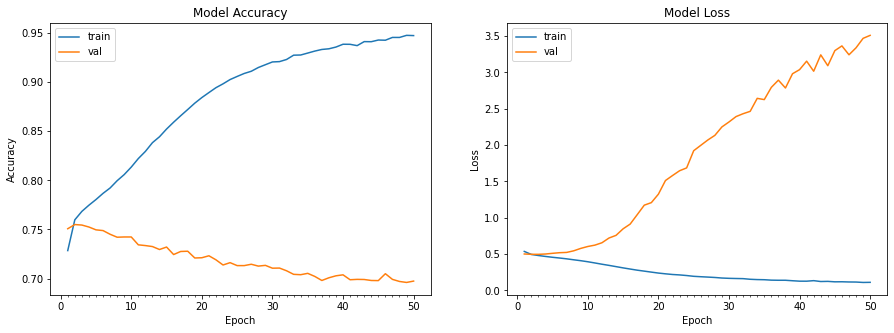

In [214]:
plot_model_history(history)

In [222]:
score = model.evaluate(x_test, y_test, batch_size = 100)
print("Accuracy :",score[1]) # précision du modèle

200/200 [==============================] - 2s 10ms/step - loss: 3.3987 - accuracy: 0.7038
Accuracy : 0.7038499712944031


#V. Tests de prédiction

*get_sentiment* permet de savoir si le tweet est positif ou négatif, selon le score calculé par le modèle

In [216]:
def get_sentiment(score):
  if score < 0.5 :
    return "Negative sentiment"
  else : 
    return "Positive sentiment"

*clean_phrase* permet de faire toutes les étapes de prétraitement du texte vues à l'étape 2) Traitement des tweets

In [217]:
def clean_phrase(text):
  text.replace('[^a-zA-Z#]',' ')
  text.lower()
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',text)
  text = re.sub('@[^\s]+',' ', text)
  text = re.sub('[\s]+', ' ', text)
  text = re.sub(r'#([^\s]+)', r' ', text)
  text = ' '.join(word for word in text.split() if word not in stopWords)
  tokens = text.split()
  tokensStem = [stemmer.stem(i) for i in tokens]
  textClean = ' '.join(tokensStem)
  
  return textClean

predict() est la fonction finale qui va prédire si une phrase est positive ou négative

In [218]:
def predict(text):
  # clean the text
  textClean = clean_phrase(text)
  # Tokenize text
  x_test = pad_sequences(tokenizer.texts_to_sequences([textClean]), maxlen=max_len)
  # Predict
  score = model.predict([x_test])[0]
  # Decode sentiment
  label = get_sentiment(score)

  return {"Label": label, "Score": float(score)}

In [219]:
predict("I liked the burger")

{'Label': 'Positive sentiment', 'Score': 1.0}

In [220]:
predict("Covid is a really sad period")

{'Label': 'Negative sentiment', 'Score': 9.470858640270308e-05}